### Notebook 3: Getting Started on Modelling with Multinomial Naive Bayes

In this notebook I will experiment with preprocessing tools and hyperparameter tuning to try to acheive the best Naive Bayes Classifier model that can discern which subreddit page a submission title corresponds to.

A quick note about this notebook: it contains ALOT of models, like 15 of them. I like to be intentional about each model and tweak one variable at a time to get a good feel for how one model compares to the next. If you don't want to look through all of the models, please go down to Model 4 (Pipe4/GS4) and check that one out- it turned out to be the best model in this notebook. It utilized the custom Lemmatizer with TfidfVectorizer, which gave me a test score of ~93%. It also had the best Recall/Sensitivity score of .89 and lowest false negative value of 11%. I tested many more models after this one, but used this one as best and then moved on to the next notebook (Notebook 04) after realizing below that I had further cleaning to do to my data as a result of the modelling here. So, if you like, you can move on to Notebook 04 to see my final Naive Bayes models, or scroll down below to follow my modelling process from the very beginning. Enjoy!

Step 1: Imports and my model evaluation functions to make life easier.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import recall_score, confusion_matrix

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

import warnings
warnings.filterwarnings('ignore')

In [2]:
def eval_model(pipe, X_train, X_test, y_train, y_test):
    """function for evaluating a model inside of a pipeline."""
#     y_train_preds = pipe.predict(X_train)
#     rmse_train = mean_squared_error(y_train, y_train_preds, squared=False)
    y_test_preds = pipe.predict(X_test)
    print(f'Your train score is: {cross_val_score(pipe, X_train, y_train)}')
    print(f'Your mean train score is: {np.mean(cross_val_score(pipe, X_train, y_train))}')
    print(f'Your test score is: {cross_val_score(pipe, X_test, y_test)}')
    print(f'Your mean test score is: {np.mean(cross_val_score(pipe, X_test, y_test))}')
    print(f'Your test recall/sensitivity score is: {recall_score(y_test, y_test_preds)}')
    print(f'Your confusion matrix is: {confusion_matrix(y_test, y_test_preds, normalize = "true")}')
#    plot_confusion_matrix(logreg, X_test, y_test, display_labels=['alive', 'dead'])
#     plot_roc_curve(logreg, X_test, y_test);
#     print(f'Your train RMSE is: {rmse_train}')
#     print(f'Your test RMSE is: {rmse_test}')

In [3]:
def pipe_coefs(pipe, vectorizer):
    """ This function will give you a dataframe with your features and their coefficients/importances so you can sort them"""
    features = pipe.named_steps[vectorizer].get_feature_names()
    coefficients = pipe.named_steps['multinomialnb'].coef_
    flattened_coefs = [val for sublist in coefficients for val in sublist]
    pipe_coefs_df = pd.DataFrame({'coefs': flattened_coefs, 'names': features})
    return pipe_coefs_df

In [4]:
def eval_model_gs(gs, X_train, X_test, y_train, y_test):
    """function to get the model results when using GridSearchCV"""
#     y_train_preds = gs.predict(X_train)
#     rmse_train = mean_squared_error(y_train, y_train_preds, squared=False)
    y_test_preds = gs.predict(X_test)
#     rmse_test = mean_squared_error(y_test, y_test_preds, squared=False)
    print(f'Your train score is: {gs.score(X_train, y_train)}')
    print(f'Your test score is: {gs.score(X_test, y_test)}')
    print(f'Your best test params were: {gs.best_params_}')
    print(f'Your test recall/sensitivity score is: {recall_score(y_test, y_test_preds)}')
    print(f'Your confusion matrix is: {confusion_matrix(y_test, y_test_preds, normalize = "true")}')
#     print(f'Your train RMSE is: {rmse_train}')
#     print(f'Your test RMSE is: {rmse_test}')

In [5]:
def get_coefs_gs(gs, vectorizer):
    """function to get the coefficients when using GridSearchCV"""
    coefs = gs.best_estimator_.named_steps['multinomialnb'].coef_
    flattened_coefs = [val for sublist in coefs for val in sublist]
    feats = gs.best_estimator_.named_steps[vectorizer].get_feature_names()
    gs_coef_df = pd.DataFrame({'coefs': flattened_coefs, 'names': feats})
    return gs_coef_df

Step 2: Read in the combined dataset I saved in Notebook 2

In [6]:
all_titles = pd.read_csv('./data/combined_data_with_selftext.csv', index_col=0)

In [7]:
all_titles

,subreddit,selftext,title
0,gameofthrones,NaN,Some genius explains how the Trump riots is ‘G...
1,gameofthrones,NaN,"Jagjeet Sandhu Age, Career, Personal Life- Bio..."
2,gameofthrones,NaN,"Kaagaz: plot, cast, review. Kaagaz is a 2021 I..."
3,gameofthrones,NaN,"Urvi Singh Age, Career, Personal Life- Biograp..."
4,gameofthrones,NaN,"Abhishek Banerjee: Wiki, age, birthday &amp; f..."
...,...,...,...
10195,lotr,I read the lotr for the first time a few month...,lotr is calling me back
10196,lotr,NaN,"Fly, you fools!"
10197,lotr,NaN,Cool fire pit
10198,lotr,NaN,Who remembers when LOTR first premiered?


Now I will drop the 'selftext' column so we can just model using the submission titles.

In [8]:
data = all_titles.drop('selftext', axis=1)

To begin my modelling with Naive Bayes, my plan of attack is to first run a null model for comparison, then run a first-pass simple model using CountVectorizer with stop words (since we learned that would probably be helpful in Notebook 2), Standard Scaler, and Naive Bayes. After those first two steps, I will add complexity and use GridSearch to optimize hyperparameters.

Additionally, I'm using accuracy score, recall/sensitivity score, and the confusion matrix to evaluate my models. The accuracy score will be assessed on both the train and test sets, and I'll be keeping an eye out for overfitting (when train score is much higher than test score). The Recall/Sensitivity score will give me an estimate of which model optimizes the True Positive Rate best (how well I'm doing at getting the best True Positive Predictions and minimizing the False Negative Predictions). I'm also going to be looking at the lower left value of a confusion matrix after each model, as that will give me the False Negative value, which I want to be as low as possible. I would rather my friend let in some Lord of the Rings posts rather than filter out some legit Game of Thrones posts, so I'm looking to reduce the False Negative score as much as positive (remember that LOTR is 0, so getting that prediction wrong would be a false negative).

First Step: Set up my X and Y and split into train and test sets

In [9]:
X = all_titles['title']
y = all_titles['subreddit'].map({'gameofthrones': 1, 'lotr': 0})

In [10]:
y[0]

1

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
X_train.shape

(7650,)

In [13]:
y_train.shape

(7650,)

Second Step: Make a null model using DummyClassifier

In [14]:
dc = DummyClassifier(strategy='most_frequent')

In [15]:
dc.fit(X_train, y_train)
y_dummy_preds = dc.predict(X_test)
y_dummy_preds

array([1, 1, 1, ..., 1, 1, 1])

In [16]:
#My dummy predictions are ready for when we run our first simple model

Third Step: Run a first-pass simple model and evaluate initial scores

In [17]:
pipe1 = make_pipeline(CountVectorizer(stop_words='english'), StandardScaler(with_mean=False), MultinomialNB())

In [18]:
pipe1.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('multinomialnb', MultinomialNB())])

In [19]:
eval_model(pipe1, X_train, X_test, y_train, y_test)

Your train score is: [0.88235294 0.85686275 0.86078431 0.87320261 0.84836601]
Your mean train score is: 0.864313725490196
Your test score is: [0.84117647 0.85882353 0.86666667 0.84313725 0.83921569]
Your mean test score is: 0.8498039215686275
Your test recall/sensitivity score is: 0.8592
Your confusion matrix is: [[0.87   0.13  ]
 [0.1408 0.8592]]


In [20]:
pipe1.score(X_test, y_dummy_preds)

0.48745098039215684

Initial model assessment: scores are starting out pretty high. It looks like I might have some overfitting going on because my train score is a little higher than my test score, but overall I think I'm seeing some initial success. Also, I would expect my null model to be around 50% accuracy, since I have an equal number of titles from both classes. So a dummy score of ~50% makes sense.

Now I will move onto my Step Three: Making a GridSearchCV to test more CountVectorizer parameters and experiment with alpha values in the Naive Bayes algorithm. 

In [21]:
pipe2 = make_pipeline(CountVectorizer(), StandardScaler(with_mean=False), MultinomialNB())
params2 = {'countvectorizer__stop_words': [None, 'english'],
          'countvectorizer__max_features': [None, 250, 500],
          'countvectorizer__ngram_range': [(1,1),(1,3)],
          'multinomialnb__alpha': [0, 0.00001, 0.5, 1.0]}

In [22]:
gs2 = GridSearchCV(pipe2, param_grid=params2, n_jobs=-1)

In [23]:
gs2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [None, 250, 500],
                         'countvectorizer__ngram_range': [(1, 1), (1, 3)],
                         'countvectorizer__stop_words': [None, 'english'],
                         'multinomialnb__alpha': [0, 1e-05, 0.5, 1.0]})

In [24]:
eval_model_gs(gs2, X_train, X_test, y_train, y_test)

Your train score is: 0.9959477124183006
Your test score is: 0.903921568627451
Your best test params were: {'countvectorizer__max_features': None, 'countvectorizer__ngram_range': (1, 3), 'countvectorizer__stop_words': None, 'multinomialnb__alpha': 1.0}
Your test recall/sensitivity score is: 0.9112
Your confusion matrix is: [[0.89692308 0.10307692]
 [0.0888     0.9112    ]]


Wow, pretty good recall score and very low false negative score of .088.

In [25]:
gs2_coefs = get_coefs_gs(gs2, 'countvectorizer')
gs2_coefs

,coefs,names
0,-12.014657,00
1,-15.542960,00 00
2,-15.542960,00 00 you
3,-15.542960,00 cad
4,-15.542960,00 cad on
...,...,...
95673,-11.060297,𝐏𝐂 2gb
95674,-11.060297,𝐏𝐂 2gb ram
95675,-11.060297,𝟐𝟎𝟕𝟕
95676,-11.060297,𝟐𝟎𝟕𝟕 in


In [26]:
gs2_coefs.nlargest(10, 'coefs')

,coefs,names
70145,-7.499172,spoilers
74476,-7.630729,the
52122,-7.773456,no
4890,-7.787469,and
52241,-7.798127,no spoilers
216,-7.855833,14
38983,-7.885475,is
11436,-7.890171,bigg
12500,-7.913962,boss
11439,-7.914966,bigg boss


Well my scores improved, but I'm still a little overfit. There is a delta of ~7-8% between my train set and my test set. My best model did not utilize the stop words parameter, no max feature limits, and an ngram range of (1,3) in the count vectorizer, and the Naive Bayes algorithm preferred the default alpha value of 1.0. This is good to know! I think next model I'd like to run will utilize a Tokenizer. 

A brief recap on what each of these NLP terms are because I want to make sure I understand what I'm doing. So, a Tokenizer takes in a string and breaks it up according to a pattern, and different tokenizers have their own unique algorthim to identify patterns (for example a sentence tokenizer vs a word tokenizer, each are different patterns). A vectorizer splits the text string up such that each word (or combo of words if using ngrams) is a vector, which can then be used for modelling. The CountVectorizer works differently than a Tfidf Vectorizer, although we can use a tokenizer in both and both vectorizers utilize similar hyperparameters. The CountVector simply vectorizes based on the words, whereas the Tfidf Vectorizer assigns a score based on which words (or ngram group of words) appear less frequently (but importantly) across all of our "documents". The words (or combination of words) that appear often in one document vs another get more importance, or predictive power, because they make some documents unique relative to the others. Finally, it is sometimes useful to use a tokenizer inside of a vectorizer, because pre-emptively splitting up words that belong to a pattern can help optimize the vectorizer's separation of the words. Plus, tokenizers can help ensure we are removing useless word items like symbols, or keeping money-related strings together, before passing them into a vectorizer. 

In [27]:
#write a custom class
class LemmaTokenizer:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.lemmatizer.lemmatize(t) for t in word_tokenize(doc)]

In [79]:
pipe2b = make_pipeline(CountVectorizer(tokenizer = LemmaTokenizer()), MultinomialNB())

In [80]:
pipe2b.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(tokenizer=<__main__.LemmaTokenizer object at 0x7f8906c19850>)),
                ('multinomialnb', MultinomialNB())])

In [83]:
eval_model(pipe2b, X_train, X_test, y_train, y_test)

Your train score is: [0.9124183  0.91568627 0.93398693 0.91895425 0.90784314]
Your mean train score is: 0.9177777777777777
Your test score is: [0.91372549 0.91764706 0.91568627 0.90980392 0.90588235]
Your mean test score is: 0.9125490196078431
Your test recall/sensitivity score is: 0.8472
Your confusion matrix is: [[0.97461538 0.02538462]
 [0.1528     0.8472    ]]


It appears that although my overall scores are lower, I have reduced the overfitting problem quite a bit, so that is good. A ~92% test score is pretty decent, I would say.

In [32]:
pipe3 = make_pipeline(CountVectorizer(tokenizer = LemmaTokenizer()), StandardScaler(with_mean=False), MultinomialNB())

In [33]:
pipe3.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(tokenizer=<__main__.LemmaTokenizer object at 0x7f891ffdd1f0>)),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('multinomialnb', MultinomialNB())])

In [53]:
eval_model(pipe3, X_train, X_test, y_train, y_test)

Your train score is: [0.89215686 0.86470588 0.87908497 0.87843137 0.86666667]
Your mean train score is: 0.8762091503267975
Your test score is: [0.84901961 0.85294118 0.85490196 0.82941176 0.84313725]
Your mean test score is: 0.8458823529411765
Your test recall/sensitivity score is: 0.852
Your confusion matrix is: [[0.90769231 0.09230769]
 [0.148      0.852     ]]


Interesting observation: I just noticed that if I add in StandardScaler, my results become overfit again. Interesting...

Now I would like to try a similar pipeline using Tfidf.

In [36]:
pipe4 = make_pipeline(TfidfVectorizer(tokenizer = LemmaTokenizer()), MultinomialNB())

In [37]:
params_4= {'tfidfvectorizer__stop_words': [None, 'english'],
         'tfidfvectorizer__max_features': [None, 500, 1000],
         'multinomialnb__alpha': [0, 0.00001, 0.5, 1.0]}

In [38]:
gs4 = GridSearchCV(pipe4, param_grid=params_4, n_jobs=-1)

In [39]:
gs4.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(tokenizer=<__main__.LemmaTokenizer object at 0x7f8919d90550>)),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'multinomialnb__alpha': [0, 1e-05, 0.5, 1.0],
                         'tfidfvectorizer__max_features': [None, 500, 1000],
                         'tfidfvectorizer__stop_words': [None, 'english']})

In [40]:
eval_model_gs(gs4, X_train, X_test, y_train, y_test)

Your train score is: 0.9626143790849673
Your test score is: 0.9243137254901961
Your best test params were: {'multinomialnb__alpha': 1.0, 'tfidfvectorizer__max_features': None, 'tfidfvectorizer__stop_words': 'english'}
Your test recall/sensitivity score is: 0.8928
Your confusion matrix is: [[0.95461538 0.04538462]
 [0.1072     0.8928    ]]


Okay, this is interesting. I still have a bit of overfitting with this model, and the TfidfVectorizer wanted to utilize the stop words parameter. 

In [41]:
gs4_coefs = get_coefs_gs(gs4, 'tfidfvectorizer')
gs4_coefs

,coefs,names
0,-5.810685,!
1,-8.173463,#
2,-8.706905,$
3,-8.988022,%
4,-6.674939,&
...,...,...
9149,-9.977482,🧙🏻‍♂️🧝🏼‍♂️🧙🏻‍♀️🧝🏻‍♀️
9150,-9.977482,🧝‍♀️
9151,-9.977482,🧝‍♂️
9152,-9.977482,🧝🏻‍♂️


In [42]:
gs4_coefs.iloc[30:50,]

,coefs,names
30,-9.627042,'jealous
31,-9.622338,'kaleshi
32,-9.565730,'light
33,-8.995924,'ll
34,-9.977482,'lord
35,-8.238271,'m
36,-9.033606,'main
37,-9.781624,'mera
38,-9.977482,'mountains
39,-9.977482,'only


In [43]:
gs4_coefs.iloc[-1,-1]

'🧭'

In [44]:
type(gs4_coefs.iloc[-1, -1])

str

In [45]:
gs4_coefs.nlargest(10, 'coefs')

,coefs,names
6538,-4.480256,spoiler
403,-4.560347,]
401,-4.561278,[
67,-4.765667,","
395,-4.890906,:
79,-4.938346,...
77,-5.154512,.
2520,-5.169738,episode
5858,-5.297313,roadies
5801,-5.331101,revolution


Alright! I clearly need to get some of these symbols and emojies out of my models! I'm going to try to do that by utilizing max_features for both the CountVectorizer and Tfidf model scenarios. We'll see if that strategy improves my modelling at all.

In [46]:
pipe5 = make_pipeline(CountVectorizer(tokenizer = LemmaTokenizer(), lowercase=True, stop_words='english', max_features = 1_000), MultinomialNB())

In [47]:
pipe5.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1000, stop_words='english',
                                 tokenizer=<__main__.LemmaTokenizer object at 0x7f8920159760>)),
                ('multinomialnb', MultinomialNB())])

In [54]:
eval_model(pipe5, X_train, X_test, y_train, y_test)

Your train score is: [0.89869281 0.90784314 0.91372549 0.89542484 0.89411765]
Your mean train score is: 0.9019607843137255
Your test score is: [0.90588235 0.90980392 0.90588235 0.9        0.89803922]
Your mean test score is: 0.903921568627451
Your test recall/sensitivity score is: 0.8488
Your confusion matrix is: [[0.93076923 0.06923077]
 [0.1512     0.8488    ]]


In [50]:
pipe5_coefs_df = pipe_coefs(pipe5, 'countvectorizer')

In [51]:
pipe5_coefs_df.nlargest(10, 'coefs')

,coefs,names
14,-3.030385,","
18,-3.277778,...
59,-3.290517,:
16,-3.579315,.
751,-3.689315,spoiler
64,-3.749214,[
65,-3.750979,]
144,-4.037484,bigg
159,-4.086921,bos
28,-4.114492,14


In [55]:
pipe5_coefs_df.nsmallest(10, 'coefs')

,coefs,names
77,-10.78272,added
95,-10.78272,anniversary
102,-10.78272,aragorn
110,-10.78272,arwen
116,-10.78272,audiobook
128,-10.78272,balrog
145,-10.78272,bilbo
151,-10.78272,blockchain
152,-10.78272,blu
154,-10.78272,blue


In [56]:
pipe6 = make_pipeline(CountVectorizer(tokenizer = LemmaTokenizer(), lowercase=True, stop_words='english', max_features = 500), MultinomialNB())

In [57]:
pipe6.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=500, stop_words='english',
                                 tokenizer=<__main__.LemmaTokenizer object at 0x7f891a7436d0>)),
                ('multinomialnb', MultinomialNB())])

In [58]:
eval_model(pipe6, X_train, X_test, y_train, y_test)

Your train score is: [0.88300654 0.89019608 0.89346405 0.87777778 0.87254902]
Your mean train score is: 0.8833986928104576
Your test score is: [0.89411765 0.90980392 0.90392157 0.89607843 0.90392157]
Your mean test score is: 0.9015686274509804
Your test recall/sensitivity score is: 0.856
Your confusion matrix is: [[0.89846154 0.10153846]
 [0.144      0.856     ]]


In [59]:
pipe6_coefs_df = pipe_coefs(pipe6, 'countvectorizer')

In [60]:
pipe6_coefs_df.nlargest(10, 'coefs')

,coefs,names
11,-2.918316,","
15,-3.165710,...
39,-3.178449,:
13,-3.467246,.
379,-3.577247,spoiler
43,-3.637145,[
44,-3.638910,]
82,-3.925415,bigg
91,-3.974853,bos
20,-4.002423,14


In [61]:
pipe6_coefs_df.nsmallest(10, 'coefs')

,coefs,names
61,-10.670652,aragorn
83,-10.670652,bilbo
87,-10.670652,blockchain
154,-10.670652,elf
156,-10.670652,elvish
176,-10.670652,fellowship
184,-10.670652,frodo
187,-10.670652,galadriel
189,-10.670652,gandalf
194,-10.670652,gollum


In [62]:
pipe7 = make_pipeline(TfidfVectorizer(tokenizer = LemmaTokenizer(), lowercase=True, stop_words='english', max_features = 1_000), MultinomialNB())

In [63]:
pipe7.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=1000, stop_words='english',
                                 tokenizer=<__main__.LemmaTokenizer object at 0x7f891ed2d730>)),
                ('multinomialnb', MultinomialNB())])

In [64]:
eval_model(pipe7, X_train, X_test, y_train, y_test)

Your train score is: [0.90849673 0.91503268 0.92156863 0.90718954 0.90522876]
Your mean train score is: 0.9115032679738562
Your test score is: [0.91960784 0.91960784 0.90980392 0.90588235 0.90196078]
Your mean test score is: 0.9113725490196078
Your test recall/sensitivity score is: 0.872
Your confusion matrix is: [[0.92538462 0.07461538]
 [0.128      0.872     ]]


In [65]:
pipe7_coefs_df = pipe_coefs(pipe7, 'tfidfvectorizer')

In [66]:
pipe7_coefs_df.nlargest(10, 'coefs')

,coefs,names
751,-3.578532,spoiler
65,-3.644315,]
64,-3.644775,[
14,-3.947578,","
59,-4.083258,:
18,-4.129737,...
16,-4.314560,.
297,-4.509051,episode
144,-4.515464,bigg
62,-4.523469,?


In [67]:
pipe7_coefs_df.nsmallest(10, 'coefs')

,coefs,names
77,-9.387544,added
95,-9.387544,anniversary
102,-9.387544,aragorn
110,-9.387544,arwen
116,-9.387544,audiobook
128,-9.387544,balrog
145,-9.387544,bilbo
151,-9.387544,blockchain
152,-9.387544,blu
154,-9.387544,blue


In [68]:
pipe8 = make_pipeline(TfidfVectorizer(tokenizer = LemmaTokenizer(), lowercase=True, stop_words='english', max_features = 500), MultinomialNB())

In [69]:
pipe8.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=500, stop_words='english',
                                 tokenizer=<__main__.LemmaTokenizer object at 0x7f8906253d60>)),
                ('multinomialnb', MultinomialNB())])

In [70]:
eval_model(pipe8, X_train, X_test, y_train, y_test)

Your train score is: [0.8875817  0.89869281 0.90392157 0.88431373 0.88039216]
Your mean train score is: 0.8909803921568628
Your test score is: [0.89215686 0.91176471 0.90980392 0.90588235 0.90196078]
Your mean test score is: 0.9043137254901961
Your test recall/sensitivity score is: 0.876
Your confusion matrix is: [[0.89461538 0.10538462]
 [0.124      0.876     ]]


In [71]:
pipe8_coefs_df = pipe_coefs(pipe8, 'tfidfvectorizer')

In [72]:
pipe8_coefs_df.nlargest(10, 'coefs')

,coefs,names
379,-3.363346,spoiler
44,-3.425938,]
43,-3.427465,[
11,-3.722264,","
39,-3.883598,:
15,-3.919770,...
13,-4.059590,.
42,-4.311691,?
82,-4.328895,bigg
91,-4.366611,bos


In [73]:
pipe8_coefs_df.nsmallest(10, 'coefs')

,coefs,names
61,-9.297688,aragorn
83,-9.297688,bilbo
87,-9.297688,blockchain
154,-9.297688,elf
156,-9.297688,elvish
176,-9.297688,fellowship
184,-9.297688,frodo
187,-9.297688,galadriel
189,-9.297688,gandalf
194,-9.297688,gollum


Well, I think I have completed my first/initial round of modelling using Multinomial Naive Bayes. My best model was number 4, utilizing the custom Lemmatizer with TfidfVectorizer, which gave me a test score of ~93%. It also had the best Recall/Sensitivity score of .89 and lowest false negative value of 11%. I'm fairly happy with that, but I wonder if cleaning the data of the symbols and emojis will give me a better result. I'm going to make a nice plot of this model's largest/most important features for my presentation.

In [74]:
gs4_top_words = gs4_coefs.nlargest(10, 'coefs')
gs4_top_words.head(2)

,coefs,names
6538,-4.480256,spoiler
403,-4.560347,]


In [75]:
gs4_top_words2 = gs4_top_words.copy()

In [76]:
gs4_top_words2['coefs_abs']  = np.absolute(gs4_top_words2['coefs'])
gs4_top_words2.head(2)

,coefs,names,coefs_abs
6538,-4.480256,spoiler,4.480256
403,-4.560347,],4.560347


In [77]:
gs4_top_words2 = gs4_top_words2.drop('coefs', axis = 1)

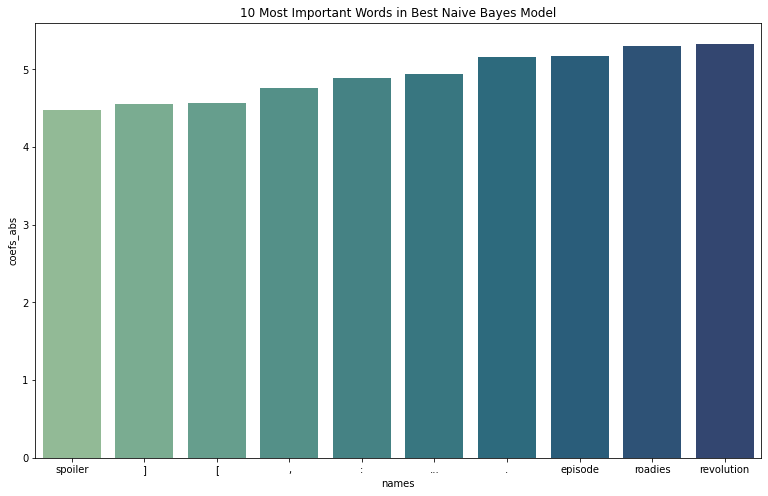

In [78]:
ax, fig = plt.subplots(figsize = (13, 8))

sns.barplot(x="names", y="coefs_abs", data=gs4_top_words2, palette = 'crest')

plt.title('10 Most Important Words in Best Naive Bayes Model');

Overall, what have I learned here? The CountVectorizer and TfidfVectorizer are giving me very similar results when I test the similar hyperparameters. I don't see a need to use StandardScaler here, so I won't continue using it. Additionally, I was able to eliminate the emojis from my features by limiting the max_features, but I still have quite a few symbols in my features so I need to get rid of those next. I am going to go back to my EDA notebook and eliminate those features from my dataset and save it out, so they are just gone from my modelling moving forward. I may also start a new Naive Bayes modelling notebook so that I can continue modelling after what I've learned here, and then experiment with n_gram range as my next feature to test. 